# The Porto Seguro kaggle challenge

## 1. Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., `ind` , `reg`, `car`, `calc`). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

## 2. File descriptions

- `train.csv` contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- `test.csv` contains the test data.

## 3. Aim

- Build a classifier using the training dataset that leads to a good ROC and Precision / Recall curve on the testing set
- The notebook should describe your steps, explain what you do and should run entirely without bugs. It should contain some descriptive statistics and quick study, to understand some things about the data...
- It must end with plots of the ROC and precision/recall curves obtained on the testing dataset

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.impute import SimpleImputer

# Use the path to your filename

#Chemin Kenny
path = ''

#Chemin Mickaël
#path = '/home/chopin/Bureau/M2MOdata/machine_learning/tp2challenge'

df = pd.read_csv(os.path.join(path, 'train.csv'))
df.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [2]:
df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
lignes = df.shape[0]
colonnes = df.shape[1]
print("Le jeu de données de training contient {0} lignes et {1} colonnes".format(lignes, colonnes))

Le jeu de données de training contient 595212 lignes et 59 colonnes


# 1. Analyse exploratoire des données

## 1)	Etude des données brutes

### Données manquantes

In [4]:
#df.isnull()
Nombre_de_donnees_manquantes=df.isna().sum()
Nombre_de_donnees_manquantes

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


Aucune donnée manquante n'a été détectée ici. Il n'y a donc que celles qui ont codées par la valeur -1. On relève donc les données manquantes en changeant les -1 en NaN et via le test isna()

In [5]:
donnees=df.replace(-1, np.NaN)

In [6]:
Nombre_de_donnees_manquantes=donnees.isna().sum()
Nombre_de_donnees_manquantes

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        216
ps_ind_03              0
ps_ind_04_cat         83
ps_ind_05_cat       5809
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         107772
ps_car_01_cat        107
ps_car_02_cat          5
ps_car_03_cat     411231
ps_car_04_cat          0
ps_car_05_cat     266551
ps_car_06_cat          0
ps_car_07_cat      11489
ps_car_08_cat          0
ps_car_09_cat        569
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          42620
ps_car_15              0
ps_calc_01             0


Faisons une liste des features ayant des données manquantes :

In [7]:
val_manquantes=donnees.columns[donnees.isna().any()].tolist()
val_manquantes

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

Visualisons les données manquantes :

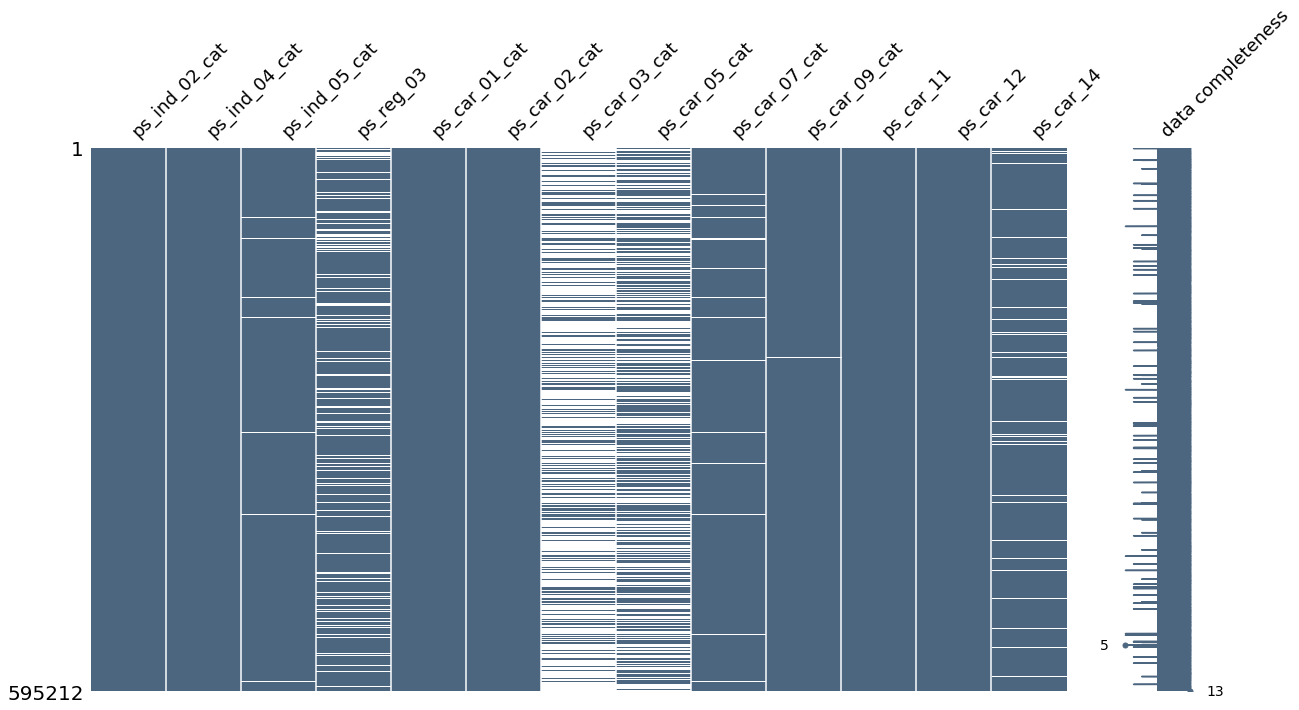

In [8]:
import missingno as msno
msno.matrix(donnees[val_manquantes],width_ratios=(10,1),figsize=(20,10),color=(0.3,0.4,0.5),fontsize=18,\
            sparkline=True,labels=True)

Calculons les pourcentages de données manquantes :

In [9]:
donnees_copy = (Nombre_de_donnees_manquantes / len(donnees)) * 100 
donnees_copy = donnees_copy.drop(donnees_copy[donnees_copy == 0].index).sort_values(ascending=False)[:30]
# Rajouter une colonne avec le nombre de NaN avec pd.concat
manquantes = pd.DataFrame({'Données manquantes en %' :donnees_copy})
manquantes

,Données manquantes en %
ps_car_03_cat,69.089837
ps_car_05_cat,44.782531
ps_reg_03,18.106490
ps_car_14,7.160474
ps_car_07_cat,1.930237
ps_ind_05_cat,0.975955
ps_car_09_cat,0.095596
ps_ind_02_cat,0.036290
ps_car_01_cat,0.017977
ps_ind_04_cat,0.013945


### Type des données

In [10]:
Counter(donnees.dtypes.values)

Counter({dtype('int64'): 39, dtype('float64'): 20})

In [11]:
donnees.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat     float64
ps_ind_03           int64
ps_ind_04_cat     float64
ps_ind_05_cat     float64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat     float64
ps_car_02_cat     float64
ps_car_03_cat     float64
ps_car_04_cat       int64
ps_car_05_cat     float64
ps_car_06_cat       int64
ps_car_07_cat     float64
ps_car_08_cat       int64
ps_car_09_cat     float64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [12]:
target=donnees.pop("target")
X , y = donnees , target

**Données binaires**
- ps_ind_06_bin 
- ps_ind_07_bin 
- ps_ind_08_bin 
- ps_ind_09_bin
- ps_ind_10_bin
- ps_ind_11_bin 
- ps_ind_12_bin 
- ps_ind_13_bin
- ps_ind_16_bin 
- ps_ind_17_bin 
- ps_ind_18_bin 
- ps_calc_15_bin
- ps_calc_16_bin 
- ps_calc_17_bin 
- ps_calc_18_bin 
- ps_calc_19_bin
- ps_calc_20_bin

In [13]:
#X.dtypes
#X.describe()
#X.corr()

bin_col=[col for col in X.columns if '_bin' in col]
X_bin=X.loc[:,bin_col]

for col in bin_col:
    donnees[col] = donnees[col].astype('bool')

**Données catégorielles**
- ps_ind_02_cat
- ps_ind_04_cat 
- ps_ind_05_cat 
- ps_car_01_cat
- ps_car_02_cat
- ps_car_03_cat
- ps_car_04_cat 
- ps_car_05_cat 
- ps_car_06_cat 
- ps_car_07_cat
- ps_car_08_cat 
- ps_car_09_cat 
- ps_car_10_cat 
- ps_car_11_cat

In [14]:
cat_col=[col for col in X.columns if '_cat' in col]
X_cat=X.loc[:,cat_col]

for col in cat_col:
    X[col] = X[col].astype('category')

**Données continues**
- ps_ind_01 
- ps_ind_03 
- ps_ind_14 
- ps_ind_15 
- ps_reg_01
- ps_reg_02
- ps_reg_03 
- ps_car_11 
- ps_car_12 
- ps_car_13 
- ps_car_14
- ps_car_15 
- ps_calc_01 
- ps_calc_02 
- ps_calc_03 
- ps_calc_04
- ps_calc_05 
- ps_calc_06 
- ps_calc_07 
- ps_calc_08 
- ps_calc_09
- ps_calc_10 
- ps_calc_11 
- ps_calc_12 
- ps_calc_13
- ps_calc_14

In [15]:
cont_col=[col for col in X.columns if col[-3:] not in ['bin', 'cat']]
X_cont=X.loc[:,cont_col]

## 2) Visualisation `pandas` + `seaborn` du jeu de données

In [16]:
X_cont.dtypes

id              int64
ps_ind_01       int64
ps_ind_03       int64
ps_ind_14       int64
ps_ind_15       int64
ps_reg_01     float64
ps_reg_02     float64
ps_reg_03     float64
ps_car_11     float64
ps_car_12     float64
ps_car_13     float64
ps_car_14     float64
ps_car_15     float64
ps_calc_01    float64
ps_calc_02    float64
ps_calc_03    float64
ps_calc_04      int64
ps_calc_05      int64
ps_calc_06      int64
ps_calc_07      int64
ps_calc_08      int64
ps_calc_09      int64
ps_calc_10      int64
ps_calc_11      int64
ps_calc_12      int64
ps_calc_13      int64
ps_calc_14      int64
dtype: object

### Corrélation des features continues

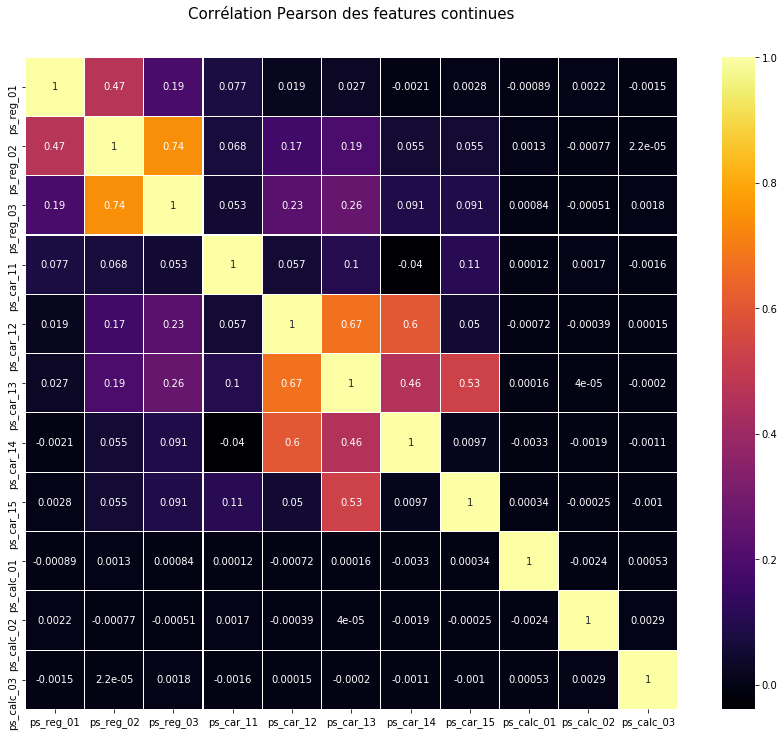

In [17]:
X_float = X_cont.select_dtypes(include=['float64'])
colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Corrélation Pearson des features continues', y=1.05, size=15)
sns.heatmap(X_float.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Corrélation des features discrètes

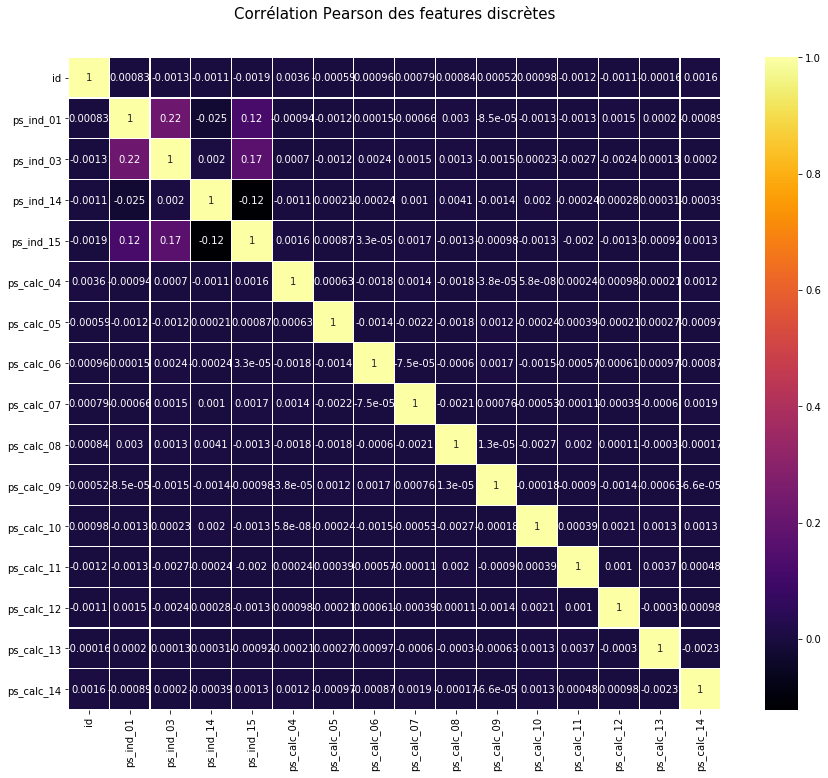

In [18]:
X_int = X.select_dtypes(include=['int64'])
colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Corrélation Pearson des features discrètes', y=1.05, size=15)
sns.heatmap(X_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Distribution des features

#### Catégorielles

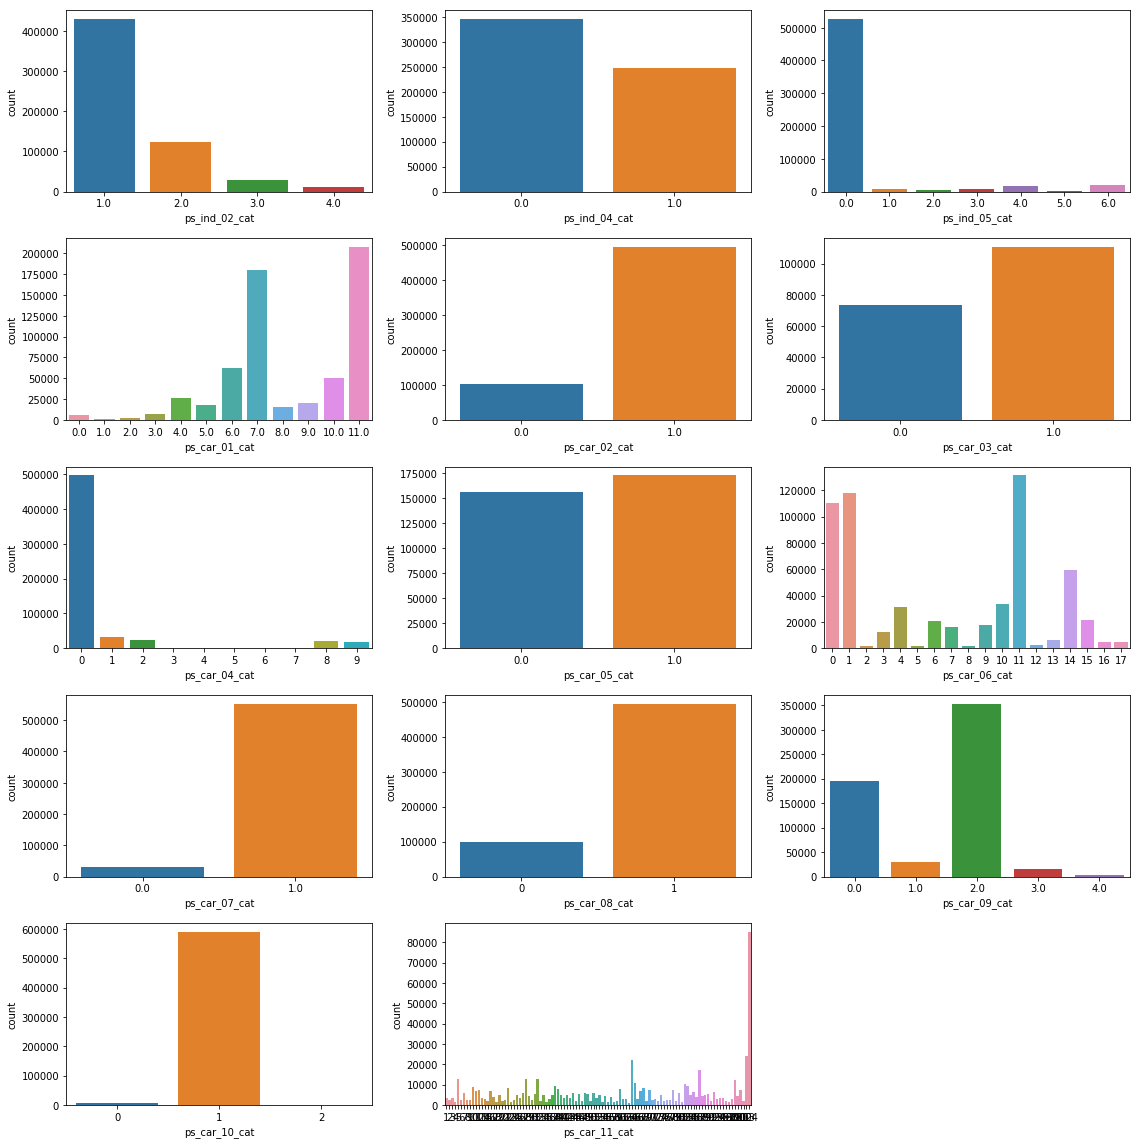

In [19]:
fig , axes = plt.subplots(nrows=5,ncols=3,figsize=(16,16))
for i , colname in enumerate(cat_col):
    sns.countplot(colname,data=X_cat,ax=fig.axes[i])
plt.tight_layout()
fig.delaxes(axes[4][2])

#### Binaires

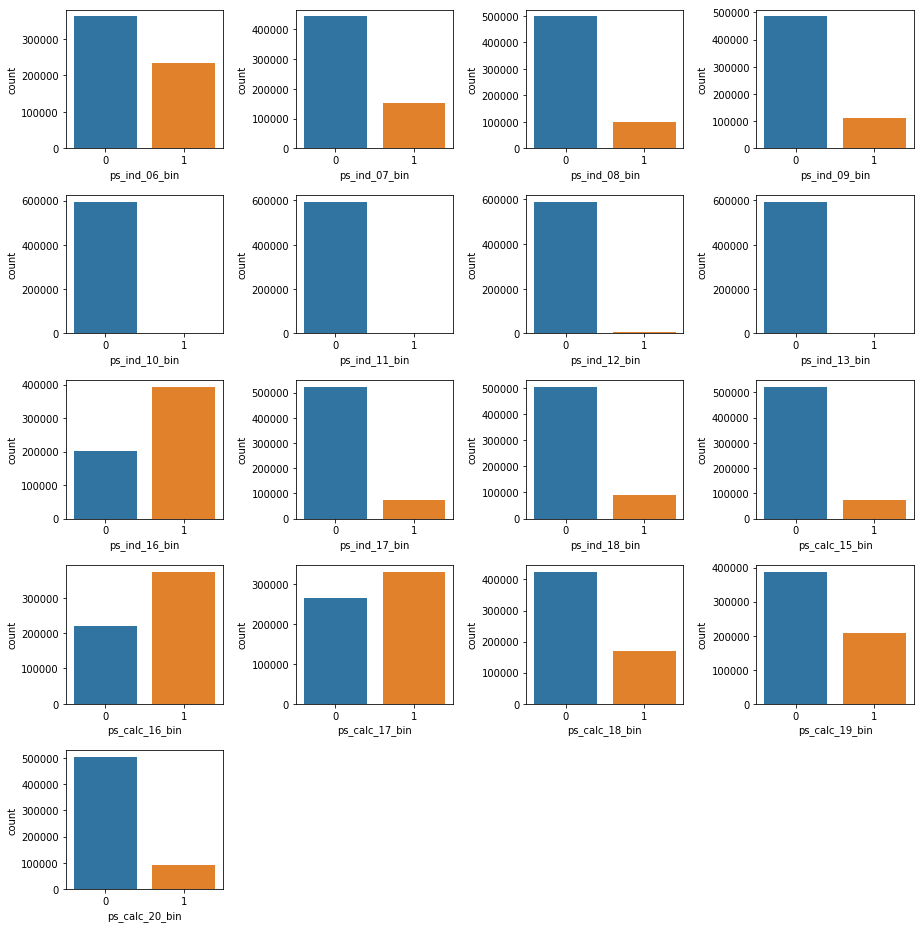

In [20]:
fig , axes = plt.subplots(nrows=5,ncols=4,figsize=(13,13))
for i , colname in enumerate(bin_col):
    sns.countplot(colname,data=X_bin,ax=fig.axes[i])
plt.tight_layout()
for i in range(1,4):
    fig.delaxes(axes[4][i])

#### Continues

In [21]:
X_cont.describe(include='all')

,id,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,487440.000000,595207.000000,595211.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,1.900378,4.423318,0.012451,7.299922,0.610991,0.439184,0.894047,2.346100,0.379947,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,4.293678e+05,1.983789,2.699902,0.127545,3.546042,0.287643,0.404264,0.345413,0.832495,0.058300,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,7.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.100000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,2.000000,0.000000,5.000000,0.400000,0.200000,0.633443,2.000000,0.316228,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,7.435475e+05,1.000000,4.000000,0.000000,7.000000,0.700000,0.300000,0.801561,3.000000,0.374166,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,1.115549e+06,3.000000,6.000000,0.000000,10.000000,0.900000,0.600000,1.083974,3.000000,0.400000,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,1.488027e+06,7.000000,11.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [22]:
# histogrammes
#g = sns.FacetGrid(X_cont, col=cont_col[0]) 
#g.map(sns.distplot, "you")

In [23]:
#sns.distplot(X_cont.(X_cont.columns[1]))

### Distribution de la variable cible

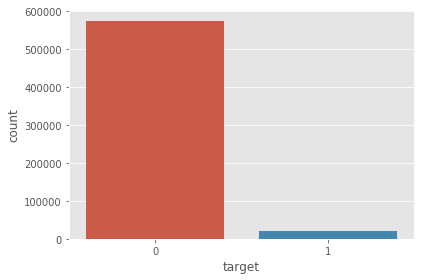

In [24]:
plt.style.use('ggplot')
sns.despine(left=True)
sns.countplot(x=y, data=X)

plt.tight_layout()
#donnees.target
#Mettre les valeurs

In [25]:
X_cont.shape

(595212, 27)

In [26]:
X.columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

# 2. Préparation des données pour l'entraînement des classifieurs  

### Suppression de features 

Les features ps_car_03_cat, ps_car_05_cat et ps_reg_03 ont trop de valeurs manquantes. On va donc les supprimer :

In [27]:
cat1 = X_cat.shape[1]
cont1 = X_cont.shape[1]
dropfeat1 = X_cat.pop('ps_car_03_cat')
dropfeat2 = X_cat.pop('ps_car_05_cat')
dropfeat3 = X_cont.pop('ps_reg_03')
cont_col.remove('ps_reg_03')
cat2 = X_cat.shape[1]
cont2 = X_cont.shape[1]
print("On a bien supprimé " + str(cat1-cat2+cont1-cont2)+ " features")

On a bien supprimé 3 features


On supprime également la colonne id (à cause de sa valeur prédictive nulle) :

In [28]:
_ = X_cont.pop('id')
cont_col.remove('id')
X_cont.shape[1]

25

In [29]:
len(cont_col)

25

Remplissage des données manquantes en remplaçant les NaN par la moyenne des valeurs de la colonne :

In [30]:
remp = SimpleImputer(missing_values=np.NaN, strategy="mean")

X_cont['ps_car_11']=remp.fit_transform(X_cont[['ps_car_11']]).ravel()
X_cont['ps_car_12']=remp.fit_transform(X_cont[['ps_car_12']]).ravel()
X_cont['ps_car_14']=remp.fit_transform(X_cont[['ps_car_14']]).ravel()
#donnees['ps_reg_03']=remp.fit_transform(donnees[['ps_reg_03']]).ravel()   VALEUR SUPPRIMEE

Retirons les derniers NaN :

In [31]:
X_cont = X_cont.dropna()
X_cat = X_cat.dropna()
X_bin = X_bin.dropna()

### Encodage des données catégorielles 

In [32]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_cat_bin = pd.get_dummies(X_cat, prefix_sep='#', drop_first=True)

In [33]:
X_cat_bin.head(n=10)

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,2.0,1.0,0.0,10.0,1.0,0,4,1.0,0,0.0,1,12
1,1.0,0.0,0.0,11.0,1.0,0,11,1.0,1,2.0,1,19
2,4.0,1.0,0.0,7.0,1.0,0,14,1.0,1,2.0,1,60
3,1.0,0.0,0.0,7.0,1.0,0,11,1.0,1,3.0,1,104
4,2.0,1.0,0.0,11.0,1.0,0,14,1.0,1,2.0,1,82
5,1.0,0.0,0.0,10.0,0.0,0,14,1.0,1,0.0,1,104
6,1.0,1.0,0.0,6.0,1.0,0,11,1.0,1,0.0,1,99
7,1.0,0.0,0.0,11.0,1.0,0,11,1.0,1,2.0,1,30
8,1.0,1.0,0.0,10.0,1.0,0,14,1.0,1,0.0,1,68
9,1.0,0.0,0.0,11.0,0.0,1,14,1.0,1,2.0,1,104


### Centrage et réduction des variables continues 

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit(X_cont)
X_cont = scaler.transform(X_cont)

c:\users\kémy\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
X_cont

array([[0.28571429, 0.45454545, 0.        , ..., 0.1       , 0.38461538,
        0.34782609],
       [0.14285714, 0.63636364, 0.        , ..., 0.1       , 0.07692308,
        0.39130435],
       [0.71428571, 0.81818182, 0.        , ..., 0.2       , 0.53846154,
        0.30434783],
       ...,
       [0.14285714, 0.90909091, 0.        , ..., 0.2       , 0.15384615,
        0.26086957],
       [0.71428571, 0.27272727, 0.        , ..., 0.1       , 0.30769231,
        0.08695652],
       [0.        , 0.72727273, 0.        , ..., 0.4       , 0.23076923,
        0.34782609]])

X_cont est devenu un `numpy.array` donc on le reconvertit en `pandas.DataFrame`

In [36]:
X_cont = pd.DataFrame(X_cont, columns = cont_col)
X_cont.describe()
X_cont.index

RangeIndex(start=0, stop=595212, step=1)

### Matrice des features

In [37]:
X = pd.concat((X_bin, X_cat_bin, X_cont), axis=1)

In [38]:
X.columns

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15',
       'ps_reg_01', 'ps_reg_02', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
       'ps_calc_14'],
      dtype='object')

In [39]:
X.describe(include='all')

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,...,0.314314,0.768945,0.333980,0.722590,0.334148,0.337344,0.286389,0.144192,0.220945,0.327784
std,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,...,0.189155,0.133431,0.157174,0.145967,0.178136,0.116184,0.122783,0.120296,0.130376,0.119420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.700000,0.222222,0.600000,0.142857,0.240000,0.210526,0.100000,0.153846,0.260870
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.333333,0.800000,0.333333,0.700000,0.285714,0.320000,0.263158,0.100000,0.230769,0.304348
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.500000,0.900000,0.444444,0.800000,0.428571,0.400000,0.368421,0.200000,0.307692,0.391304
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
X.head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,0,1,0,0,0,0,0,0,0,1,...,0.166667,1.0,0.111111,0.8,0.142857,0.20,0.473684,0.1,0.384615,0.347826
1,0,0,1,0,0,0,0,0,0,0,...,0.166667,0.9,0.555556,0.6,0.142857,0.28,0.157895,0.1,0.076923,0.391304
2,0,0,1,0,0,0,0,0,1,0,...,0.333333,0.9,0.111111,0.6,0.285714,0.28,0.210526,0.2,0.538462,0.304348
3,1,0,0,0,0,0,0,0,1,0,...,0.666667,0.7,0.111111,0.6,0.571429,0.08,0.105263,0.2,0.307692,0.391304
4,1,0,0,0,0,0,0,0,1,0,...,0.333333,0.6,0.333333,0.8,0.285714,0.48,0.157895,0.1,0.076923,0.130435


In [41]:
X.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            595202, 595203, 595204, 595205, 595206, 595207, 595208, 595209,
            595210, 595211],
           dtype='int64', length=595212)

In [42]:
#On a retiré des données, donc la liste des indices de la dataframe n'est plus contigue. 
#On réinitialise cette liste :

In [43]:
X.reset_index(inplace=True, drop=True)

In [44]:
X.head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
0,0,1,0,0,0,0,0,0,0,1,...,0.166667,1.0,0.111111,0.8,0.142857,0.20,0.473684,0.1,0.384615,0.347826
1,0,0,1,0,0,0,0,0,0,0,...,0.166667,0.9,0.555556,0.6,0.142857,0.28,0.157895,0.1,0.076923,0.391304
2,0,0,1,0,0,0,0,0,1,0,...,0.333333,0.9,0.111111,0.6,0.285714,0.28,0.210526,0.2,0.538462,0.304348
3,1,0,0,0,0,0,0,0,1,0,...,0.666667,0.7,0.111111,0.6,0.571429,0.08,0.105263,0.2,0.307692,0.391304
4,1,0,0,0,0,0,0,0,1,0,...,0.333333,0.6,0.333333,0.8,0.285714,0.48,0.157895,0.1,0.076923,0.130435


In [45]:
X.shape

(595212, 54)

In [46]:
y.shape

(595212,)

### Enregistrement des données traitées 

On utilise `pickle` pour enregistrer les données traitées

In [47]:
import pickle as pkl

with open('données_traitées.pkl', 'wb') as f:
    pkl.dump(X, f)